In [ ]:
#pip install openmeteo-requests
#pip install requests-cache retry-requests numpy pandas


In [39]:
import openmeteo_requests

import pandas as pd
import requests_cache
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": 50.85,
	"longitude": 4.35,
	"hourly": [
			"temperature_2m",           # 1. Temperature
			"wind_speed_10m",           # 2. Wind Speed
			"shortwave_radiation",      # 3. Solar Irradiance (GHI)
			"cloud_cover",              # 4. Cloud Cover
			"precipitation",            # 5. Precipitation
			"relative_humidity_2m",     # 6. Humidity
			"surface_pressure"          # 7. Surface Pressure
		],
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone difference to GMT+1: {response.UtcOffsetSeconds()+1}s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
temperature_2m = hourly.Variables(0).ValuesAsNumpy()
wind_speed_10m = hourly.Variables(1).ValuesAsNumpy()
shortwave_radiation = hourly.Variables(2).ValuesAsNumpy()
cloud_cover = hourly.Variables(3).ValuesAsNumpy()
precipitation = hourly.Variables(4).ValuesAsNumpy()
relative_humidity_2m = hourly.Variables(4).ValuesAsNumpy()
surface_pressure = hourly.Variables(4).ValuesAsNumpy()



hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end =  pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = temperature_2m
hourly_data["wind_speed_10m"] = wind_speed_10m
hourly_data["shortwave_radiation"] = shortwave_radiation
hourly_data["cloud_cover"] = cloud_cover
hourly_data["precipitation"] = precipitation
hourly_data["relative_humidity_2m"] = relative_humidity_2m
hourly_data["surface_pressure"] = surface_pressure

hourly_dataframe = pd.DataFrame(data = hourly_data)
print("\nHourly data\n", hourly_dataframe)

Coordinates: 50.854000091552734°N 4.349999904632568°E
Elevation: 27.0 m asl
Timezone difference to GMT+1: 1s

Hourly data
                          date  temperature_2m  wind_speed_10m  \
0   2025-10-29 00:00:00+00:00       11.695499       17.639999   
1   2025-10-29 01:00:00+00:00       11.245500       17.280001   
2   2025-10-29 02:00:00+00:00       11.495500       18.000000   
3   2025-10-29 03:00:00+00:00       11.445499       16.919998   
4   2025-10-29 04:00:00+00:00       11.095500       17.280001   
..                        ...             ...             ...   
163 2025-11-04 19:00:00+00:00       12.658000       13.896187   
164 2025-11-04 20:00:00+00:00       12.208000       13.577776   
165 2025-11-04 21:00:00+00:00       11.608000       13.184308   
166 2025-11-04 22:00:00+00:00       11.058001       12.924953   
167 2025-11-04 23:00:00+00:00       10.558001       12.886039   

     shortwave_radiation  cloud_cover  precipitation  relative_humidity_2m  \
0                 

In [43]:
hourly_dataframe.to_csv("hourly_weather_data.csv", index = False)

array([[<Axes: xlabel='date'>, <Axes: xlabel='date'>],
       [<Axes: xlabel='date'>, <Axes: xlabel='date'>],
       [<Axes: xlabel='date'>, <Axes: xlabel='date'>],
       [<Axes: xlabel='date'>, <Axes: xlabel='date'>]], dtype=object)

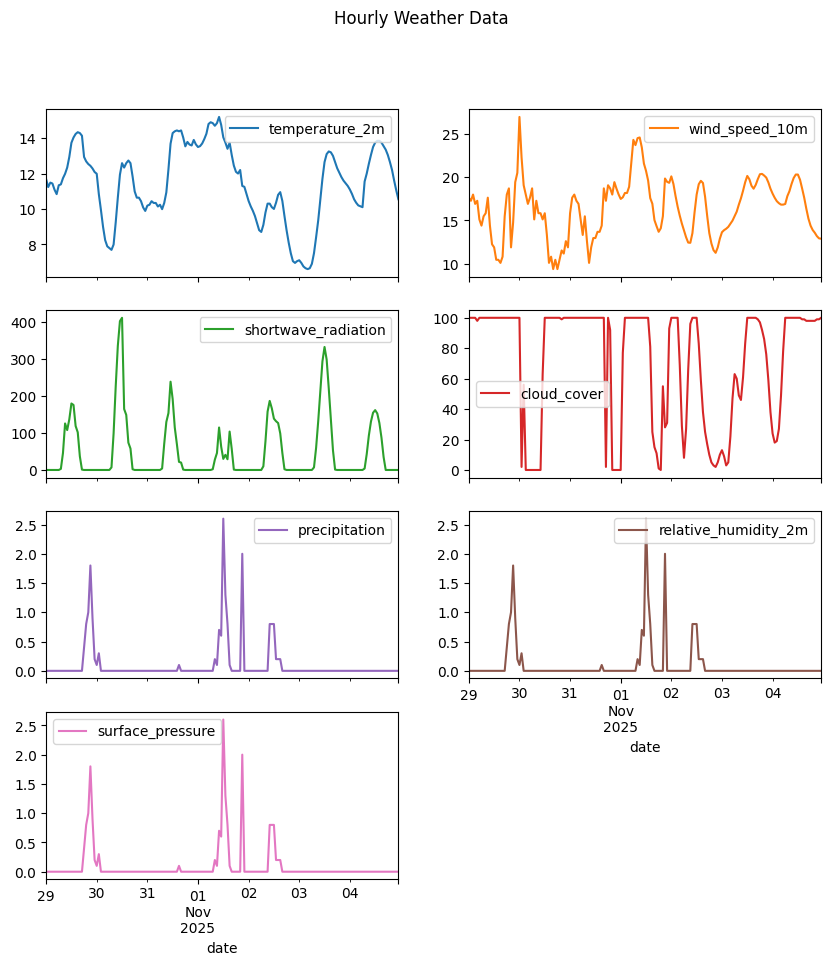

In [48]:
hourly_dataframe.plot(x='date', y=['temperature_2m', 'wind_speed_10m', 'shortwave_radiation', 'cloud_cover', 'precipitation', 'relative_humidity_2m', 'surface_pressure'], subplots=True, layout=(4,2), figsize=(10,10), title='Hourly Weather Data')